In [2]:
# Setup Keys
import os
from dotenv import load_dotenv
load_dotenv()


# Make Agent Class

In [4]:
# Import package
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import HumanMessage, AIMessage, SystemMessage

# Build LLM
llm = init_chat_model(
    model="claude-haiku-4-5-20251001",
    temperature=0.1
)

# Build agent
checkpointer = InMemorySaver()

agent = create_agent(
  model = llm,
  tools = [],
  middleware = [],
  system_prompt = """
    You are a personal AI assistant
    """,
  # context_schema = Context,
  # response_format = ResponseFormat, ## can make it run longer because the LLM need to match the raw response to the format semantic
  checkpointer = checkpointer
)

# Prompt
config = {'configurable': {'thread_id': 1}} # to determine the "session_id", if this change the previous context is lost

message = HumanMessage(
    content=[
      {'type':'text',
       'text':"""
          Hello World
          """
      },
    ]
)

response = agent.invoke(
    {"messages": [message]},
    config = config,
)

print(f'Prompt : {response['messages'][0].content}')
print(f'Answer : {response['messages'][-1].content}')

Prompt : [{'type': 'text', 'text': '\n          Hello World\n          '}]
Answer : # Hello! 👋

Welcome! I'm your personal AI assistant. How can I help you today?

Feel free to ask me anything—whether it's:
- **Questions** on various topics
- **Writing** help (emails, essays, creative content)
- **Problem-solving** and brainstorming
- **Learning** and explanations
- **Coding** assistance
- Or just a friendly chat!

What's on your mind?


In [5]:
# Import package
import json
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool

# Building tools
@tool("calculate")
def calculate(math_formula: str) :
  """
  Tool to do simple match calculation

  Input : Inferred the math formula from the text

  Output : The result of match calculation based on the inferred match formula
  """

  return eval(math_formula)

@tool("average_dog_weight")
def average_dog_weight(name: str) -> str:
  """
  Tool to get the average weight of a dog breed, you might want to make the text to be lower case first before inferring dog name

  Input: The dog breed name (e.g., "Scottish Terrier", "Border Collie", "Toy Poodle")

  Output: The average weight of that dog breed
  """
  # Normalize the input to handle case variations
  name_lower = name.lower()

  if "scottish terrier" in name_lower:
      return "Scottish Terriers average 20 lbs"
  elif "border collie" in name_lower:
      return "Border Collies average weight is 37 lbs"
  elif "toy poodle" in name_lower:
      return "Toy Poodles average weight is 7 lbs"
  else:
      return "An average dog weights 50 lbs"


# Building agent
class LearningAgent:
  def __init__(self, system: str, tools, middleware):
    self.system = SystemMessage(
        content=[
          {'type':'text',
          'text':f"""
              {system}
              """.strip()
          },
        ]
    )
    self.log_message = []
    self.config = {'configurable': {'thread_id': 3}}
    self.checkpointer = InMemorySaver()

    # create agent
    self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0
    )
    self.agent = create_agent(
            model=self.llm,
            middleware=middleware,
            tools=tools,
            system_prompt=self.system,
            checkpointer = self.checkpointer
        )

  # To get response from the LLM
  def execute(self, message: str, answer_type: str='simple'):

    # agent will return final answer only
    if answer_type == 'simple':

      input_message = HumanMessage(
        content=[
          {'type':'text',
          'text':f"""
              {message}
              """
          },
          ]

      )
      self.log_message.append(input_message)

      response = self.agent.invoke(
          {"messages": self.log_message},
          config = self.config,
      )

      response_message = AIMessage(
        content=[
          {'type':'text',
          'text':f"""
              {response['messages'][-1].content}
              """
          },
          ]

      )
      self.log_message.append(response_message)

      print(f'Prompt : {message}')
      print(f'Answer : {response['messages'][-1].content}')

    elif answer_type == 'complex':
      input_message = input_message = HumanMessage(
        content=[
          {'type':'text',
          'text':f"""
              {message}
              """
          },
          ]
      )
      self.log_message.append(input_message)

      print(f'Prompt : {message}')

      # Stream the agent's execution to see intermediate steps
      step_count = 0
      for event in self.agent.stream(
          {"messages": self.log_message},
          config=self.config,
          stream_mode="values"
      ):
          # Get the last message in each event
          last_message = event['messages'][-1]

          # Display AI thoughts/reasoning
          if hasattr(last_message, 'content') and isinstance(last_message.content, str):
              if last_message.content and last_message != input_message:
                  step_count += 1
                  print(f'\n--- STEP {step_count} ---')
                  print(f'THOUGHT: {last_message.content}\n')

          # Display tool calls (Actions)
          if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
              for tool_call in last_message.tool_calls:
                  print(f'ACTION: Calling tool "{tool_call["name"]}"')
                  print(f'INPUT: {tool_call["args"]}\n')

          # Display tool results (Observations)
          if isinstance(last_message, ToolMessage):
              print(f'OBSERVATION: {last_message.content}')
              print(f'{"-"*40}\n')


# Define system prompt
initial_prompt = """
  You run in a loop of Thought, Action, PAUSE, Observation.
  At the end of the loop you output an Answer
  Use Thought to describe your thoughts about the question you have been asked.
  Use Action to run one of the actions available to you
  Use Pause to think about whether the action and the though is aligned, if yes continue with the observation, if no go back to Thought and Action
  Observation will be the result of running those actions.

  Your available actions are:

  calculate:
  e.g. calculate: 4 * 7 / 3
  Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

  average_dog_weight:
  e.g. average_dog_weight: Collie
  returns average weight of a dog when given the breed

  Example session:

  Question: How much does a Bulldog weigh?
  Thought: I should look the dogs weight using average_dog_weight
  Action: average_dog_weight: Bulldog
  PAUSE, the Action aligned with the Thought

  You will be called again with this:

  Observation: A Bulldog weights 51 lbs

  You then output:

  Answer: A bulldog weights 51 lbs
  """

bot = LearningAgent(initial_prompt, [calculate, average_dog_weight], [])
bot.execute("""I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight""", answer_type='simple')


Prompt : I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
Answer : Answer: Your two dogs have a combined weight of 57 lbs. The Border Collie averages 37 lbs and the Scottish Terrier averages 20 lbs.


In [6]:
bot.execute("""I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight""", answer_type='complex')

Prompt : I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
ACTION: Calling tool "average_dog_weight"
INPUT: {'name': 'Border Collie'}

ACTION: Calling tool "average_dog_weight"
INPUT: {'name': 'Scottish Terrier'}


--- STEP 1 ---
THOUGHT: Scottish Terriers average 20 lbs

OBSERVATION: Scottish Terriers average 20 lbs
----------------------------------------

ACTION: Calling tool "calculate"
INPUT: {'math_formula': '37 + 20'}


--- STEP 2 ---
THOUGHT: 57

OBSERVATION: 57
----------------------------------------


--- STEP 3 ---
THOUGHT: Answer: Your two dogs have a combined weight of 57 lbs. The Border Collie averages 37 lbs and the Scottish Terrier averages 20 lbs.



# Explore using LangGraph

In [186]:
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_community.tools.tavily_search import TavilySearchResults

# Agent state
class AgentState(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

# Build tool
tavily_search_results_json = TavilySearchResults(max_results=2)

# Build model with LangGraph
class LearningAgent:
  def __init__(self, system: str, tools, middleware):
    # to initiate the chatting model
    self.system = SystemMessage(
        content=[
          {'type':'text',
          'text':f"""
              {system}
              """.strip()
          },
        ]
    )
    self.log_message = []
    self.config = {'configurable': {'thread_id': 11}}
    self.checkpointer = InMemorySaver()

    # Store tools as dictionary
    self.tools = {t.name: t for t in tools}

    # create agent
    self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0
    )
    self.agent = create_agent(
            model=self.llm,
            middleware=middleware,
            tools=tools,
            system_prompt=self.system,
            checkpointer = self.checkpointer
        )

  def execute(self, message: str, answer_type: str = 'compact'):
    """Execute the agent with a user message"""

    if answer_type == 'compact':
      input_message = HumanMessage(content=message)

      print(f'\n{"="*60}')
      print(f'USER QUESTION: {message}')
      print(f'{"="*60}\n')

      # Run the graph
      result = self.agent.invoke(
          {'messages': [input_message]},
          config=self.config
      )

      # Get final answer
      final_answer = result['messages'][-1].content

      print(f'\n{"="*60}')
      print(f'FINAL ANSWER: {final_answer}')
      print(f'{"="*60}\n')

    elif answer_type == 'stream':
      input_message = HumanMessage(content=message)

      print(f'\n{"="*60}')
      print(f'USER QUESTION: {message}')
      print(f'{"="*60}\n')

      step_count = 0

      # Stream the agent's execution to see intermediate steps
      for event in self.agent.stream(
          {'messages': [input_message]},
          config=self.config,
          stream_mode="values"
      ):
          # Get the last message in each event
          last_message = event['messages'][-1]

          # Skip the input message
          if last_message == input_message:
              continue

          step_count += 1
          print(f'{"─"*60}')
          print(f'STEP {step_count}')
          print(f'{"─"*60}')

          # Check if it's an AI message with tool calls
          if isinstance(last_message, AIMessage):
              if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                  # AI decided to use tools
                  print(f'🤔 THOUGHT: Agent wants to use {len(last_message.tool_calls)} tool(s)\n')

                  for tool_call in last_message.tool_calls:
                      print(f'🔧 ACTION: Calling tool "{tool_call["name"]}"')
                      print(f'   Arguments: {tool_call["args"]}\n')

              elif last_message.content:
                  # AI provided final answer
                  print(f'💡 FINAL THOUGHT: Agent has formulated the answer\n')
                  print(f'RESPONSE: {last_message.content}\n')

          # Check if it's a tool result message
          elif isinstance(last_message, ToolMessage):
              print(f'📊 OBSERVATION: Tool "{last_message.name}" returned results')

              # Show preview of result
              result_preview = str(last_message.content)[:200]
              if len(str(last_message.content)) > 200:
                  result_preview += "..."
              print(f'   Result preview: {result_preview}\n')

    else:
      raise ValueError(f"answer_type must be 'compact' or 'stream', got '{answer_type}'")


# Define system prompt
initial_prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

bot = LearningAgent(initial_prompt, [tavily_search_results_json], [])
bot.execute('What is the weather in sf?', 'stream')



USER QUESTION: What is the weather in sf?

────────────────────────────────────────────────────────────
STEP 1
────────────────────────────────────────────────────────────
🤔 THOUGHT: Agent wants to use 1 tool(s)

🔧 ACTION: Calling tool "tavily_search_results_json"
   Arguments: {'query': 'weather in San Francisco'}

────────────────────────────────────────────────────────────
STEP 2
────────────────────────────────────────────────────────────
📊 OBSERVATION: Tool "tavily_search_results_json" returned results
   Result preview: [{"title": "San Francisco January 2026 Historical Weather Data (California ...", "url": "https://weatherspark.com/h/m/557/2026/1/Historical-Weather-in-January-2026-in-San-Francisco-California-United-S...

────────────────────────────────────────────────────────────
STEP 3
────────────────────────────────────────────────────────────
💡 FINAL THOUGHT: Agent has formulated the answer

RESPONSE: Based on the latest weather data for San Francisco:

**Current Weather in

In [187]:
bot.execute('What is the weather in SF and LA?', 'stream')


USER QUESTION: What is the weather in SF and LA?

────────────────────────────────────────────────────────────
STEP 1
────────────────────────────────────────────────────────────
🤔 THOUGHT: Agent wants to use 2 tool(s)

🔧 ACTION: Calling tool "tavily_search_results_json"
   Arguments: {'query': 'current weather San Francisco'}

🔧 ACTION: Calling tool "tavily_search_results_json"
   Arguments: {'query': 'current weather Los Angeles'}

────────────────────────────────────────────────────────────
STEP 2
────────────────────────────────────────────────────────────
📊 OBSERVATION: Tool "tavily_search_results_json" returned results
   Result preview: [{"title": "Weather in Los Angeles in January 2026 (California)", "url": "https://world-weather.info/forecast/usa/los_angeles/january-2026/", "content": "Detailed ⚡ Los Angeles Weather Forecast for Ja...

────────────────────────────────────────────────────────────
STEP 3
────────────────────────────────────────────────────────────
🤔 THOUGHT: Ag

In [188]:
bot.execute('How about in Jakarta', 'stream')


USER QUESTION: How about in Jakarta

────────────────────────────────────────────────────────────
STEP 1
────────────────────────────────────────────────────────────
🤔 THOUGHT: Agent wants to use 1 tool(s)

🔧 ACTION: Calling tool "tavily_search_results_json"
   Arguments: {'query': 'Jakarta weather today now'}

────────────────────────────────────────────────────────────
STEP 2
────────────────────────────────────────────────────────────
📊 OBSERVATION: Tool "tavily_search_results_json" returned results
   Result preview: [{"title": "Jakarta, Jakarta, Indonesia Weather Forecast - AccuWeather", "url": "https://www.accuweather.com/en/id/jakarta/208971/weather-forecast/208971", "content": "# Jakarta, Jakarta\n\nJakarta\n\...

────────────────────────────────────────────────────────────
STEP 3
────────────────────────────────────────────────────────────
💡 FINAL THOUGHT: Agent has formulated the answer

RESPONSE: ## **Jakarta Weather:**
- **Current Time:** 11:59 AM on February 1, 2026
- **T

In [23]:
bot.execute('Who won the super bowl in 2025? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question.', 'stream')


USER QUESTION: Who won the super bowl in 2025? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.

────────────────────────────────────────────────────────────
STEP 1
────────────────────────────────────────────────────────────
🤔 THOUGHT: Agent wants to use 1 tool(s)

🔧 ACTION: Calling tool "tavily_search_results_json"
   Arguments: {'query': 'Super Bowl 2025 winner'}

────────────────────────────────────────────────────────────
STEP 2
────────────────────────────────────────────────────────────
📊 OBSERVATION: Tool "tavily_search_results_json" returned results
   Result preview: [{"title": "Super Bowl Winners List - NFL Champions by Year - Topend Sports", "url": "https://www.topendsports.com/events/super-bowl/winners-list.htm", "content": "| No. | Year | Winner | Opposition |...

────────────────────────────────────────────────────────────
STEP 3
────────────────────────────────────────────────────────────
🤔 THOUGHT: Agent want

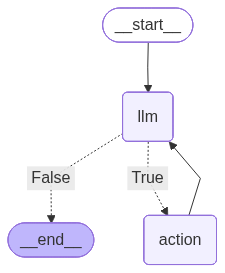

In [42]:
from IPython.display import Image, display

try:
    # Try to visualize the graph
    display(Image(bot.graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(bot.graph.get_graph().draw_ascii())

## From Claude
**Note** : LangGraph State doesn't work with create_agent wrapper, so use the init_chat_model version and bind the tools manually

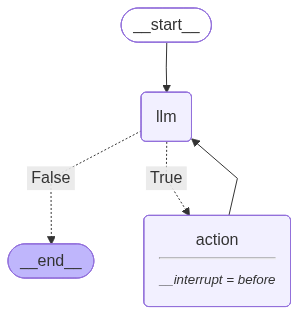

In [20]:
from IPython.display import Image, display
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import InMemorySaver
from uuid import uuid4

# Agent state
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

# Build tool
search_tool = TavilySearchResults(max_results=2)

# Build model with LangGraph
class LearningAgent:
    def __init__(self, system: str, tools, middleware):
        self.system = system
        self.log_message = []
        self.config = {'configurable': {'thread_id': 9}}
        self.checkpointer = InMemorySaver()

        # Store tools as dictionary
        self.tools = {t.name: t for t in tools}

        # create LLM with tool binding
        self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0
        )

        # Bind tools to the model
        self.llm_with_tools = self.llm.bind_tools(tools)

        # to initiate the Graph
        self.graph = StateGraph(AgentState)
        self.graph.add_node('llm', self.call_agent)
        self.graph.add_node('action', self.take_action)
        self.graph.add_conditional_edges(
            'llm',
            self.exists_action,
            {True: 'action', False: END})
        self.graph.add_edge('action', 'llm')
        self.graph.set_entry_point('llm')
        self.graph = self.graph.compile(
            checkpointer=self.checkpointer,
            )

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        # Check if tool_calls attribute exists and is not empty
        if hasattr(result, 'tool_calls') and result.tool_calls:
            print(f"✓ Tool calls detected: {len(result.tool_calls)}")
            return True
        print("✗ No tool calls - ending")
        return False

    def call_agent(self, state: AgentState):
        messages = state['messages']

        # Prepend system message if this is the first call
        if len(messages) == 1:
            system_msg = SystemMessage(content=self.system)
            messages = [system_msg] + messages

        print(f"\n→ Calling LLM with {len(messages)} message(s)...")

        # Call the LLM with tools
        response = self.llm_with_tools.invoke(messages)

        # Debug: Check if tool calls exist
        if hasattr(response, 'tool_calls') and response.tool_calls:
            print(f"✓ LLM returned {len(response.tool_calls)} tool call(s)")
            for tc in response.tool_calls:
                print(f"  - {tc['name']}: {tc['args']}")
        else:
            print("✓ LLM returned final answer")

        return {'messages': [response]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []

        print(f"\n{'='*60}")
        print(f"EXECUTING {len(tool_calls)} TOOL CALL(S)")
        print(f"{'='*60}")

        for t in tool_calls:
            print(f"\n🔧 Tool: {t['name']}")
            print(f"   Args: {t['args']}")

            result = self.tools[t['name']].invoke(t['args'])

            # Show result preview
            result_str = str(result)
            print(f"   Result: {result_str[:150]}{'...' if len(result_str) > 150 else ''}")

            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

        print(f"\n{'='*60}")
        print("⬅ Sending results back to LLM")
        print(f"{'='*60}\n")

        return {'messages': results}

    def execute(self, message: str):
        """Execute the agent with a user message"""
        input_message = HumanMessage(content=message)

        print(f'\n{"="*60}')
        print(f'👤 USER: {message}')
        print(f'{"="*60}')

        # Run the graph
        result = self.graph.invoke(
            {'messages': [input_message]},
            config=self.config
        )

        # Get final answer
        final_answer = result['messages'][-1].content

        print(f'\n{"="*60}')
        print(f'🤖 FINAL ANSWER:\n{final_answer}')
        print(f'{"="*60}\n')

        # return final_answer

# Define system prompt
initial_prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

bot = LearningAgent(initial_prompt, [search_tool], [])

# Display LangGraph structure
try:
    # Try to visualize the graph
    display(Image(bot.graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(bot.graph.get_graph().draw_ascii())

In [21]:
bot.execute('What is the weather in sf?')


👤 USER: What is the weather in sf?

→ Calling LLM with 2 message(s)...
✓ LLM returned 1 tool call(s)
  - tavily_search_results_json: {'query': 'weather in San Francisco'}
✓ Tool calls detected: 1

🤖 FINAL ANSWER:
[{'text': "I'll search for the current weather in San Francisco for you.", 'type': 'text'}, {'id': 'toolu_011GrUpy7asDypK1biPvyjzK', 'input': {'query': 'weather in San Francisco'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]



In [6]:
bot.execute('What is the weather in SF and LA?')


👤 USER: What is the weather in SF and LA?

→ Calling LLM with 5 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'weather in San Francisco'}
  - tavily_search_results_json: {'query': 'weather in Los Angeles'}
✓ Tool calls detected: 2

EXECUTING 2 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'weather in San Francisco'}
   Result: [{'title': 'San Francisco January 2026 Historical Weather Data (California ...', 'url': 'https://weatherspark.com/h/m/557/2026/1/Historical-Weather-in...

🔧 Tool: tavily_search_results_json
   Args: {'query': 'weather in Los Angeles'}
   Result: [{'title': 'Long-Range Weather Forecast for Los Angeles, CA | Almanac.com', 'url': 'https://www.almanac.com/weather/longrange/zipcode/90064', 'content...

⬅ Sending results back to LLM


→ Calling LLM with 8 message(s)...
✓ LLM returned final answer
✗ No tool calls - ending

🤖 FINAL ANSWER:
Here's the current weather comparison for both cities:

## **San Franc

In [7]:
bot.execute('Who won the super bowl in 2025? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question.')


👤 USER: Who won the super bowl in 2025? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.

→ Calling LLM with 10 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'Super Bowl 2025 winner'}
  - tavily_search_results_json: {'query': 'state GDP 2025'}
✓ Tool calls detected: 2

EXECUTING 2 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'Super Bowl 2025 winner'}
   Result: [{'title': 'Super Bowl Winners List - NFL Champions by Year - Topend Sports', 'url': 'https://www.topendsports.com/events/super-bowl/winners-list.htm'...

🔧 Tool: tavily_search_results_json
   Args: {'query': 'state GDP 2025'}
   Result: [{'title': 'Gross Domestic Product by State and Personal Income by State, 3rd ...', 'url': 'https://www.bea.gov/news/2026/gross-domestic-product-state...

⬅ Sending results back to LLM


→ Calling LLM with 13 message(s)...
✓ LLM returned 1 tool call(s)
  - tavily_search_res

## From Claude with Human in the loop

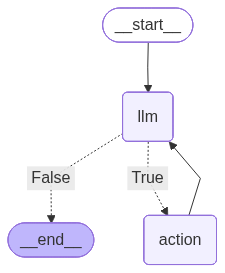

In [195]:
from IPython.display import Image, display
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated
import operator
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import InMemorySaver
from uuid import uuid4

# Agent state
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

# Build tool
search_tool = TavilySearchResults(max_results=2)

# Build model with LangGraph
class LearningAgent:
    def __init__(self, system: str, tools, middleware):
        self.system = system
        self.log_message = []
        self.config = {'configurable': {'thread_id': 9}}
        self.checkpointer = InMemorySaver()

        # Store tools as dictionary
        self.tools = {t.name: t for t in tools}

        # create LLM with tool binding
        self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0
        )

        # Bind tools to the model
        self.llm_with_tools = self.llm.bind_tools(tools)

        # to initiate the Graph
        self.graph = StateGraph(AgentState)
        self.graph.add_node('llm', self.call_agent)
        self.graph.add_node('action', self.take_action)
        self.graph.add_conditional_edges(
            'llm',
            self.exists_action,
            {True: 'action', False: END})
        self.graph.add_edge('action', 'llm')
        self.graph.set_entry_point('llm')

        # make 2 version
        self.graph_hitl = self.graph.compile(
            checkpointer=self.checkpointer,
            interrupt_before=["action"]
            )

        self.graph_np = self.graph.compile(
            checkpointer=self.checkpointer,
            )

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        # Check if tool_calls attribute exists and is not empty
        if hasattr(result, 'tool_calls') and result.tool_calls:
            print(f"✓ Tool calls detected: {len(result.tool_calls)}")
            return True
        print("✗ No tool calls - ending")
        return False

    def call_agent(self, state: AgentState):
        messages = state['messages']

        # Prepend system message if this is the first call
        if len(messages) == 1:
            system_msg = SystemMessage(content=self.system)
            messages = [system_msg] + messages

        print(f"\n→ Calling LLM with {len(messages)} message(s)...")

        # Call the LLM with tools
        response = self.llm_with_tools.invoke(messages)

        # Debug: Check if tool calls exist
        if hasattr(response, 'tool_calls') and response.tool_calls:
            print(f"✓ LLM returned {len(response.tool_calls)} tool call(s)")
            for tc in response.tool_calls:
                print(f"  - {tc['name']}: {tc['args']}")
        else:
            print("✓ LLM returned final answer")

        return {'messages': [response]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []

        print(f"\n{'='*60}")
        print(f"EXECUTING {len(tool_calls)} TOOL CALL(S)")
        print(f"{'='*60}")

        for t in tool_calls:
            print(f"\n🔧 Tool: {t['name']}")
            print(f"   Args: {t['args']}")

            result = self.tools[t['name']].invoke(t['args'])

            # Show result preview
            result_str = str(result)
            print(f"   Result: {result_str[:150]}{'...' if len(result_str) > 150 else ''}")

            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

        print(f"\n{'='*60}")
        print("⬅ Sending results back to LLM")
        print(f"{'='*60}\n")

        return {'messages': results}

    def _resolve_pending_tool_call(self):
        """Check if there are pending tool_calls without tool_results
        and resolve them before switching graphs"""

        state = self.graph_used.get_state(self.config)

        # No previous state - nothing to resolve
        if not state or not state.values:
            return

        messages = state.values.get('messages', [])

        # No messages - nothing to resolve
        if not messages:
            return

        last_message = messages[-1]

        # Check if last message is an AIMessage with unresolved tool_calls
        if (isinstance(last_message, AIMessage)
            and hasattr(last_message, 'tool_calls')
            and last_message.tool_calls):

            print("\n⚠️  Found pending tool calls from previous graph.")
            print("   Resolving them before continuing...\n")

            # Replace the last AIMessage with one that has no tool_calls
            messages[-1] = AIMessage(
                content="I was about to search for information but that action was not completed due to approval not confirmed by the user.",
                id=last_message.id
            )

            # Update the graph
            self.graph_used.update_state(
              self.config,
              {'messages': messages}
            )

            print(f"✅ Cleaned thread '{self.config}'")

    def execute(self, message: str, tool_approval: str = 'no'):
        """Execute the agent with a user message"""
        input_message = HumanMessage(content=message)

        print(f'\n{"="*60}')
        print(f'👤 USER: {message}')
        print(f'{"="*60}')

        # Run the graph
        if tool_approval == 'no' :

          # Resolve any pending tool calls before running
          self.graph_used = self.graph_np
          self._resolve_pending_tool_call()

          result = self.graph_np.invoke(
              {'messages': [input_message]},
              config=self.config
          )

          human_input = 'yes'

        elif tool_approval == 'yes' :
          # Resolve any pending tool calls before running
          self.graph_used = self.graph_hitl
          self._resolve_pending_tool_call()

          result = self.graph_hitl.invoke(
              {'messages': [input_message]},
              config=self.config
          )

          # Looping for the interrupted node
          while self.graph_hitl.get_state(self.config).next:

            state = self.graph_hitl.get_state(self.config)
            pending_tool_calls = state.values['messages'][-1].tool_calls

            print(f"\n{'='*60}")
            print("⏸️  INTERRUPTED - Agent wants to execute:")
            print(f"{'='*60}")
            for i, tc in enumerate(pending_tool_calls):
                print(f"\n  {i+1}. Tool: {tc['name']}")
                print(f"     Args: {tc['args']}")
            print(f"\n{'='*60}")

            # Get the input
            human_input = input("\n✅ Approve tool execution? (Yes/No): ").strip().lower()
            if human_input not in ['yes', 'no']:
              print('\nThe input is not recognized, will halt the process')
              human_input = 'no'

            # Invoke the LLM based on the input
            if human_input == 'no' :
              print("\n🚫 Denied! Stopping agent.\n")
              break
            else :
              print("\n👍 Approved! Continuing...\n")
              result = self.graph_hitl.invoke(
                None,
                config=self.config
            )

            self.graph_used = self.graph_hitl


        # Get final answer
        if human_input == 'yes':
          final_answer = result['messages'][-1].content

          print(f'\n{"="*60}')
          print(f'🤖 FINAL ANSWER:\n{final_answer}')
          print(f'{"="*60}\n')

        # return final_answer

# Define system prompt
initial_prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

bot = LearningAgent(initial_prompt, [search_tool], [])

# Display LangGraph structure
try:
    # Try to visualize the graph
    display(Image(bot.graph_np.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(bot.graph_np.get_graph().draw_ascii())

In [196]:
bot.execute(
  'What is the weather in sf?',
  tool_approval = 'yes'
  )


👤 USER: What is the weather in sf?

→ Calling LLM with 2 message(s)...
✓ LLM returned 1 tool call(s)
  - tavily_search_results_json: {'query': 'weather in San Francisco'}
✓ Tool calls detected: 1

⏸️  INTERRUPTED - Agent wants to execute:

  1. Tool: tavily_search_results_json
     Args: {'query': 'weather in San Francisco'}


✅ Approve tool execution? (Yes/No): yes

👍 Approved! Continuing...


EXECUTING 1 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'weather in San Francisco'}
   Result: [{'title': 'San Francisco January 2026 Historical Weather Data (California ...', 'url': 'https://weatherspark.com/h/m/557/2026/1/Historical-Weather-in...

⬅ Sending results back to LLM


→ Calling LLM with 3 message(s)...
✓ LLM returned final answer
✗ No tool calls - ending

🤖 FINAL ANSWER:
Based on the latest weather data for San Francisco:

**Current Weather in San Francisco:**
- **Temperature:** 60°F (cool)
- **Conditions:** Mostly Cloudy
- **Humidity:** 67%
- **Wind:** 3.5 

In [197]:
bot.execute(
  'What is the weather in SF and LA?',
  tool_approval = 'yes'
  )


👤 USER: What is the weather in SF and LA?

→ Calling LLM with 5 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'weather in San Francisco'}
  - tavily_search_results_json: {'query': 'weather in Los Angeles'}
✓ Tool calls detected: 2

⏸️  INTERRUPTED - Agent wants to execute:

  1. Tool: tavily_search_results_json
     Args: {'query': 'weather in San Francisco'}

  2. Tool: tavily_search_results_json
     Args: {'query': 'weather in Los Angeles'}


✅ Approve tool execution? (Yes/No): no

🚫 Denied! Stopping agent.



In [198]:
bot.execute(
  'Can you proceed with the previous inquiry, I approved it',
  tool_approval = 'no'
  )


👤 USER: Can you proceed with the previous inquiry, I approved it

⚠️  Found pending tool calls from previous graph.
   Resolving them before continuing...

✗ No tool calls - ending
✅ Cleaned thread '{'configurable': {'thread_id': '9'}}'

→ Calling LLM with 7 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'current weather San Francisco'}
  - tavily_search_results_json: {'query': 'current weather Los Angeles'}
✓ Tool calls detected: 2

EXECUTING 2 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'current weather San Francisco'}
   Result: [{'title': 'Weather in San Francisco in February 2026 (California)', 'url': 'https://world-weather.info/forecast/usa/san_francisco/february-2026/', 'c...

🔧 Tool: tavily_search_results_json
   Args: {'query': 'current weather Los Angeles'}
   Result: [{'title': 'Weather in Los Angeles in January 2026 (California)', 'url': 'https://world-weather.info/forecast/usa/los_angeles/january-2026/', 'cont

### Get the snapshot of the state

In [222]:
list_state = [i for i in bot.graph_used.get_state_history(bot.config)]
state = list_state[8]
messages = state.values.get('messages', [])
last_message = messages[-1]

In [223]:
for i, mes in enumerate(messages) :
  print(f'\nMessage Type : {i + 1}')
  print(f'\nMessage Type : {mes.type}')
  print(f"\nMessage : {mes.content}")
  print('')
  print('=' * 100)
  print('')


Message Type : 1

Message Type : human

Message : What is the weather in sf?



Message Type : 2

Message Type : ai

Message : [{'text': "I'll search for the current weather in San Francisco for you.", 'type': 'text'}, {'id': 'toolu_01C9m78gYwYqZcgyDyKY72uG', 'input': {'query': 'weather in San Francisco'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]



Message Type : 3

Message Type : tool

Message : [{'title': 'San Francisco January 2026 Historical Weather Data (California ...', 'url': 'https://weatherspark.com/h/m/557/2026/1/Historical-Weather-in-January-2026-in-San-Francisco-California-United-States', 'content': '| Today  Yesterday  Jan  2026  ---   194019501960197019801990200020102020   ---   2017201820192020202120222023202420252026   ---   SpringSummerFallWinter  JanFebMarAprMayJunJulAugSepOctNovDec   ---   12345678910111213141516171819202122232425262728293031 January 2026 Weather History in San Francisco California, United States The data for this report comes fro

In [191]:
bot.execute(
    'Who won the super bowl in 2025? In what state is the winning team headquarters located? \
  What is the GDP of that state? Answer each question.',
    tool_approval = 'yes')


👤 USER: Who won the super bowl in 2025? In what state is the winning team headquarters located?   What is the GDP of that state? Answer each question.

→ Calling LLM with 2 message(s)...
✓ LLM returned 1 tool call(s)
  - tavily_search_results_json: {'query': 'Super Bowl 2025 winner'}
✓ Tool calls detected: 1

⏸️  INTERRUPTED - Agent wants to execute:

  1. Tool: tavily_search_results_json
     Args: {'query': 'Super Bowl 2025 winner'}


✅ Approve tool execution? (Yes/No): yes

👍 Approved! Continuing...


EXECUTING 1 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'Super Bowl 2025 winner'}
   Result: [{'title': 'Super Bowl 2025: Eagles defeat Chiefs 40-22, Jalen Hurts MVP', 'url': 'https://www.nbcnews.com/sports/nfl/live-blog/super-bowl-chiefs-eagl...

⬅ Sending results back to LLM


→ Calling LLM with 3 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'Philadelphia Eagles headquarters location state'}
  - tavily_search_results_j

In [192]:
bot.execute(
    'Who won the super bowl in 2025? In what state is the winning team headquarters located? \
  What is the GDP of that state? Answer each question.',
    tool_approval = 'yes')


👤 USER: Who won the super bowl in 2025? In what state is the winning team headquarters located?   What is the GDP of that state? Answer each question.

→ Calling LLM with 8 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'Super Bowl 2025 winner'}
  - tavily_search_results_json: {'query': 'Pennsylvania GDP 2025'}
✓ Tool calls detected: 2

⏸️  INTERRUPTED - Agent wants to execute:

  1. Tool: tavily_search_results_json
     Args: {'query': 'Super Bowl 2025 winner'}

  2. Tool: tavily_search_results_json
     Args: {'query': 'Pennsylvania GDP 2025'}


✅ Approve tool execution? (Yes/No): no

🚫 Denied! Stopping agent.



In [193]:
bot.execute(
    'Who won the super bowl in 2020? In what state is the winning team headquarters located? \
  What is the GDP of that state? Answer each question.',
    tool_approval = 'yes')


👤 USER: Who won the super bowl in 2020? In what state is the winning team headquarters located?   What is the GDP of that state? Answer each question.

⚠️  Found pending tool calls from previous graph.
   Resolving them before continuing...

✗ No tool calls - ending
✅ Cleaned thread '{'configurable': {'thread_id': '9'}}'

→ Calling LLM with 10 message(s)...
✓ LLM returned 1 tool call(s)
  - tavily_search_results_json: {'query': 'Super Bowl 2020 winner'}
✓ Tool calls detected: 1

⏸️  INTERRUPTED - Agent wants to execute:

  1. Tool: tavily_search_results_json
     Args: {'query': 'Super Bowl 2020 winner'}


✅ Approve tool execution? (Yes/No): yes

👍 Approved! Continuing...


EXECUTING 1 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'Super Bowl 2020 winner'}
   Result: [{'title': 'Super Bowl LIV - Simple English Wikipedia, the free encyclopedia', 'url': 'https://simple.wikipedia.org/wiki/Super_Bowl_LIV', 'content': '...

⬅ Sending results back to LLM


→ Calling LL

In [194]:
bot.execute(
    'Can you help execture the latest request that I accidentally unapproved',
    tool_approval = 'no')


👤 USER: Can you help execture the latest request that I accidentally unapproved

⚠️  Found pending tool calls from previous graph.
   Resolving them before continuing...

✗ No tool calls - ending
✅ Cleaned thread '{'configurable': {'thread_id': '9'}}'

→ Calling LLM with 14 message(s)...
✓ LLM returned 2 tool call(s)
  - tavily_search_results_json: {'query': 'Kansas City Chiefs headquarters location state'}
  - tavily_search_results_json: {'query': 'Missouri GDP 2024 2025'}
✓ Tool calls detected: 2

EXECUTING 2 TOOL CALL(S)

🔧 Tool: tavily_search_results_json
   Args: {'query': 'Kansas City Chiefs headquarters location state'}
   Result: [{'title': 'Kansas City Chiefs - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Kansas_City_Chiefs', 'content': 'Outside of training camp and durin...

🔧 Tool: tavily_search_results_json
   Args: {'query': 'Missouri GDP 2024 2025'}
   Result: [{'title': 'States Gross Domestic Product | Missouri Economic Research and ...', 'url': 'https://meric.mo.g

# Essay Maker
With the agent flow like described in the course + adding human in the loop action to stop the essay generator if the user deemed it to be good enough

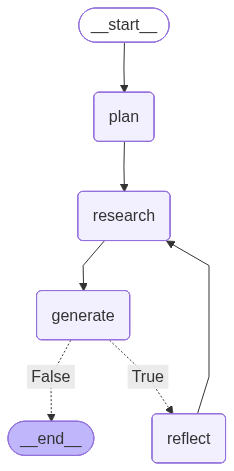

In [80]:
from IPython.display import Image, display
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated, List
from langchain_community.tools.tavily_search import TavilySearchResults
import re
import ast
import json
from pprint import pprint

# Utility function
def extract_dict_from_string(text: str) -> dict:
    """
    Extract and convert a dictionary from a string that may contain extra text.
    Tries JSON first, then falls back to ast.literal_eval.
    """
    # Strip markdown code fences if present
    cleaned = text.strip()

    if re.search(r'```json', cleaned):
      list_substr = cleaned.split("```json")
      cleaned = list_substr[1]
    if re.search(r'```', cleaned):
      list_substr = cleaned.split("```")
      cleaned = list_substr[0]

    cleaned = cleaned.strip()

    try:
        result = json.loads(cleaned)
        if isinstance(result, dict):
            return result
    except json.JSONDecodeError:
        pass

    print(f"❌ Failed to extract dict from response:\n{text[:200]}")
    return {}

# Build tool
search_tool = TavilySearchResults(max_results=2)

# Setup prompt for each task
PROMPT_PLAN = """
  You are an expert essay planner. Your job is to create a detailed and well-structured outline for an essay that will be no longer than 5 paragraphs

  Given the topic and requirements from the user, you must produce an outline that includes:
  1. A strong thesis statement
  2. An introduction section with a hook and context
  3. 3-5 main body sections, each with:
    - A clear section title
    - 2-3 key points to cover
    - A brief description of what each point should address
  4. A conclusion section that ties everything together

  Guidelines:
  - The outline should be logical and flow naturally from one section to the next
  - Each section should build upon the previous one
  - Make sure the outline directly addresses the user's requirements
  - Tailor the depth and complexity to match the required essay length and academic level

  User Input:
  {user_input}

  Agent Output in JSON Format where "" represent the keys :
  - "task", hardcoded to be 'plan'
  - "requirement", derrived from user input
  - "outline", the outline produced by the agent based on the prompt
"""

PROMPT_RESEARCH = """
  You are an expert research assistant. Your job is to gather relevant information and sources to support an essay based on a given outline.
  If the feedback is not empty, focus on doing search to help gain information to assess the feedback
  Do no more than 10 search.

  For each section and key point in the outline, you must:
  1. Search the web for relevant, credible sources using tavily_seach tool
  2. Extract key facts, statistics, quotes, or arguments that support the point
  3. Note the source URL and title for citation purposes
  4. Prioritize recent and authoritative sources (academic journals, reputable news, official reports)

  Guidelines:
  - Search for each main section and key point separately to ensure thorough coverage
  - If a search does not return useful results, try rephrasing the query
  - Avoid using low-quality or unreliable sources (forums, opinion blogs without credentials)
  - Collect at least 2-3 supporting pieces of information per key point
  - Organize the collected information according to the outline structure

  Essay Outline:
  {outline}

  Feedback:
  {feedback}

  Agent Output in JSON Format where "" represent the keys :
  - "research", that containsFor each section in the outline, provide with this format
    - Section title
    - Key Point
      - Supporting fact/quote/argument
      - Source: [title] (URL)
"""

PROMPT_GENERATE = """
  You are an expert essay writer. Your job is to write a well-structured, coherent, and polished essay based on the provided outline and research materials.

  Guidelines:
  - Follow the outline structure closely
  - Integrate the research findings naturally into the essay — do not simply list facts
  - Write in a clear, engaging, and appropriate academic tone
  - Each paragraph should have a clear topic sentence and flow logically
  - Use transitions between sections to maintain coherence
  - Support claims with evidence from the research materials
  - Include proper in-text citations where relevant (e.g., "According to [Source], ...")
  - Match the tone and complexity to the user's original requirements
  - Do NOT make up facts or statistics that are not in the provided research

  Essay Outline:
  {outline}

  Research Materials:
  {research}

  User Requirements:
  {requirement}

  Agent Output in JSON Format where "" represent the keys :
  - "essay", Write the full essay from introduction to conclusion.
"""

PROMPT_REFLECT = """
You are an expert essay editor and evaluator. Your job is to critically evaluate an essay and provide detailed, constructive feedback.

Evaluate the essay based on the following criteria:
1. Structure & Organization
   - Does the essay follow a logical flow?
   - Are transitions between sections smooth?
   - Is the outline structure well executed?

2. Thesis & Argumentation
   - Is the thesis clear and strong?
   - Does the essay consistently support the thesis?
   - Are arguments well-developed and convincing?

3. Evidence & Support
   - Is the essay well-supported with evidence?
   - Are sources credible and properly referenced?
   - Are facts and statistics used effectively?

4. Writing Quality
   - Is the tone appropriate and consistent?
   - Is the writing clear and concise?
   - Are there any grammatical or spelling errors?

5. Alignment with Requirements
   - Does the essay meet all of the user's original requirements?
   - Is the length and depth appropriate?
   - Is the target audience addressed correctly?

Essay to Evaluate:
{essay}

User's Original Requirements:
{requirement}

Agent Output in JSON Format where "" represent the keys :
- "score", give the rating from the scale of 0-10, integer only
- "feedback", the detailed evaluation along with the revision priorities
- "need_to_revised", based on the assessment of the agent return only yes/no where yes mean the draft need to be revised
"""

# Agent state
class AgentState(TypedDict):
    task: str
    requirement: str
    outline: str
    research: str
    essay: str
    feedback: str
    score: int
    need_to_revised: str
    content: List[str]
    revision_number: int
    max_revisions: int

# Build model with LangGraph
class EssayWriterAgent:
    def __init__(self, tools, middleware, max_revision:int = 3):
        self.config = {'configurable': {'thread_id': 101}}
        self.checkpointer = InMemorySaver()

        # Initiate state
        # Initialize state with defaults
        self.state: AgentState = {
            'task': '',
            'requirement': '',
            'outline': '',
            'research': '',
            'essay': '',
            'feedback': '',
            'need_to_revised' : 'yes',
            'score': 0,
            'content': [],
            'revision_number': 0,
            'max_revisions': max_revision
        }

        # Store tools as dictionary
        self.tools = {t.name: t for t in tools}

        # create LLM with tool binding
        self.llm = init_chat_model(
            model="claude-haiku-4-5-20251001",
            temperature=0.5
        )

        # Bind tools to the model
        self.llm_with_tools = self.llm.bind_tools(tools)

        # to initiate the Graph
        self.graph = StateGraph(AgentState)
        self.graph.add_node('plan', self.call_agent_plan)
        self.graph.add_node('research', self.call_agent_research)
        self.graph.add_edge('plan', 'research')
        self.graph.add_node('generate', self.call_agent_generate)
        self.graph.add_edge('research', 'generate')
        self.graph.add_conditional_edges(
            'generate',
            self.check_revision_iteration,
            {True: 'reflect', False: END})
        self.graph.add_node('reflect', self.call_agent_reflect)
        self.graph.add_edge('reflect', 'research')
        self.graph.set_entry_point('plan')

        self.graph_np = self.graph.compile(
            checkpointer=self.checkpointer,
            )

    def _update_state(self, new_dict:dict):
      """Update the state with the JSON output from the LLM response """
      for key, value in new_dict.items():
        if key in self.state:
          self.state[key] = value
          print(f"  ✅ Updated '{key}'")
        else:
          print(f"  ⚠️  Unknown key '{key}' - skipped")

    def _invoke_agent(self, human_message, answer_type:str = 'invoke'):
      """Get the LLM output and add to state"""
      self.state['content'].append(human_message)
      print(f"  ✅ Added HumanMessage to state content")

      # If it's invoke
      if answer_type == 'invoke':

        result = self.llm.invoke([human_message])

        self.state['content'].append(result)
        print(f"  ✅ Added Last AIMessage to state content")

        return result.content

      # If it's stream
      elif answer_type == 'stream':

        messages = [human_message]

        while True:
          response = self.llm_with_tools.invoke(messages)
          messages.append(response)

          # If no tool calls, LLM is done
          if not response.tool_calls:
            pprint(messages[-1].content)
            self.state['content'].append(messages[-1].content)
            print(f"  ✅ Added Last AIMessage to state content")

            return messages[-1].content

          # Execute tool calls
          for tc in response.tool_calls:
            print(f"  🔧 Calling tool: {tc['name']}")
            print(f"     Args: {tc['args']}")

            result = self.tools[tc['name']].invoke(tc['args'])

            result_str = str(result)
            print(f"     Result: {result_str[:150]}{'...' if len(result_str) > 150 else ''}\n")

            messages.append(ToolMessage(
                tool_call_id=tc['id'],
                name=tc['name'],
                content=str(result)
            ))

    def call_agent_plan(self, state: AgentState):
      """Function to call agent with the promt to produce the outline of the essay"""
      # Invoke LLM
      message = HumanMessage(content = PROMPT_PLAN.format(
          user_input=self.input_message
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING OUTLINE")
      print(f"{'='*60}")

      json_result = extract_dict_from_string(self._invoke_agent(message))
      self._update_state(json_result)

      print(f"\n=== ✅ Requirement ===")
      pprint(f"{self.state['requirement']}")
      print(f"\n=== ✅ Outline ===")
      pprint(f"{self.state['outline']}")

      return {'messages': self.state['outline']}

    def call_agent_research(self, state: AgentState):
      """Function to call agent with the prompt to produce the resource to make the essay"""
      # Invoke LLM
      message = HumanMessage(content = PROMPT_RESEARCH.format(
          outline=self.state['outline'],
          feedback=self.state['feedback']
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING RESEARCH")
      print(f"{'='*60}")

      json_result = extract_dict_from_string(self._invoke_agent(message, 'stream'))
      self._update_state(json_result)

      print(f"\n=== ✅ Research ===")
      pprint(f"{self.state['research']}")

      return {'messages': self.state['research']}

    def call_agent_generate(self, state: AgentState):
      """Function to call agent with the prompt to produce the draft for the essay"""
      # Invoke LLM
      message = HumanMessage(content = PROMPT_GENERATE.format(
          outline=self.state['outline'],
          research=self.state['research'],
          requirement=self.state['requirement'],
        )
      )

      print(f"\n{'='*60}")
      print(f"GENERATING DRAFT - ITERATION {self.state['revision_number'] + 1}")
      print(f"{'='*60}")

      json_result = extract_dict_from_string(self._invoke_agent(message))
      self._update_state(json_result)

      print(f"\n=== ✅ Essay ===")
      pprint(f"{self.state['essay']}")

      return {'messages': self.state['essay']}

    def check_revision_iteration(self, state: AgentState):
      """Function to decide whether the draft need to be assess by Reflect agent"""

      print(f"\n{'='*60}")
      print(f"DETERMINE DRAFT NEED TO BE ASSESSED ?")
      print(f"{'='*60}")

      # Draft will always be assessed if it's in the 1st iteration
      if self.state['revision_number'] == 0 :
        print(f"✅ Draft will be assessed because it's the 1st iteration ")
        return True

      # Ask the user
      elif self.state['revision_number'] > 0 :
        if self.state['need_to_revised'] == 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say it's need to be revised (Score : {self.state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()
        elif self.state['need_to_revised'] != 'yes' :
          revised_input = input(f"\n⏸️  Reflect agent say the draft is already good 👍 (Score : {self.state['score']}), would you want to proceed with revision ? (yes/no)").strip().lower()

        if revised_input == 'yes' :
          return True
        else :
          return False

    def call_agent_reflect(self, state: AgentState):
      """Function to call agent with the prompt to evaluate the essay draft"""

      # Invoke LLM
      message = HumanMessage(content = PROMPT_REFLECT.format(
          essay=self.state['essay'],
          requirement=self.state['requirement'],
        )
      )

      print(f"\n{'='*60}")
      print(f"ASSESSING DRAFT - ITERATION {self.state['revision_number'] + 1}")
      print(f"{'='*60}")
      self.state['revision_number'] += 1

      json_result = extract_dict_from_string(self._invoke_agent(message))
      self._update_state(json_result)

      print(f"\n=== ✅ Feedback ===")
      pprint(f"{self.state['feedback']}")

      print(f"\nDraft Score : {self.state['score']}")

      return {'messages': self.state['feedback']}

    def execute(self, message) :
      """Function to run the agent graph flow"""

      self.input_message = message
      print(f"\n{'='*60}")
      print(f"TASK FROM THE USER")
      print(f"{'='*60}")
      pprint(f"{self.input_message}")

      # Run the graph
      self.graph_np.invoke(
          {'messages': [self.input_message]},
          config=self.config
      )

      # Get final answer
      final_answer = self.state['essay']

      # Change it to HTML mode
      print(f"\n{'='*60}")
      print(f"CHANGE THE ESSAY TO HTML MODE")
      print(f"{'='*60}")

      PROMPT_HTML = """
        Please help change this text to HTML mode, highlight the key point from the essay with bold and red pastel color

        Text : {final_answer}
      """

      message_html = HumanMessage(content = PROMPT_HTML.format(
          final_answer=final_answer,
        )
      )
      final_answer_html = self._invoke_agent(message_html)

      print(f"\n ✅ HTML Generated")

      return final_answer_html


# Define system prompt
bot = EssayWriterAgent([search_tool], [], 3)

# Display LangGraph structure
try:
    # Try to visualize the graph
    display(Image(bot.graph_np.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")
    print("\nGraph structure (ASCII):")
    print(bot.graph_np.get_graph().draw_ascii())

In [81]:
html = bot.execute("what is the difference between langchain and langsmith")


TASK FROM THE USER
'what is the difference between langchain and langsmith'

GENERATING OUTLINE
  ✅ Added HumanMessage to state content
  ✅ Added Last AIMessage to state content
  ✅ Updated 'task'
  ✅ Updated 'requirement'
  ✅ Updated 'outline'

=== ✅ Requirement ===
('Create a 5-paragraph essay outline explaining the differences between '
 'LangChain and LangSmith')

=== ✅ Outline ===
("{'thesis_statement': 'While LangChain and LangSmith are complementary tools "
 'within the LLM ecosystem, they serve distinct purposes: LangChain is a '
 'development framework for building LLM applications, whereas LangSmith is a '
 'debugging and monitoring platform designed to optimize those applications in '
 "production.', 'introduction': {'hook': 'As large language models become "
 'increasingly central to software development, developers face the challenge '
 'of not just building LLM applications, but also maintaining and optimizing '
 "them effectively.', 'context': 'Two tools have emerged as

In [82]:
from IPython.display import HTML, display
display(HTML(html))